socket created 
socket binded to port 
socket listensing ... 

got connection from  ('127.0.0.1', 51173)
writing calibration data


<IPython.core.display.Javascript object>


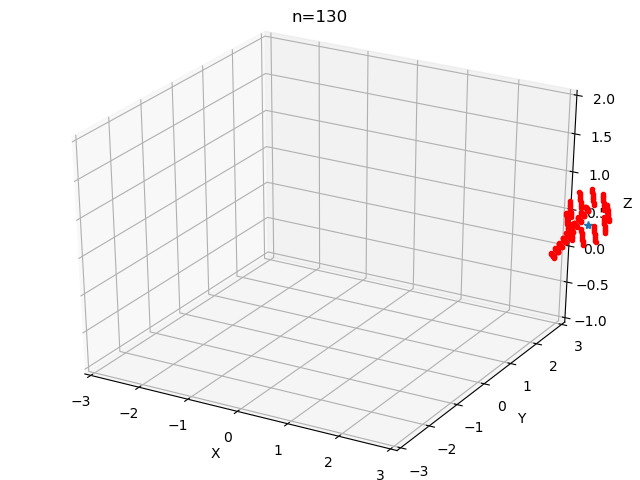

waiting for press data


In [2]:
%matplotlib notebook

def update_points_realtime(num, cyl_u,cyl_f, l,points,left_track_new,right_track_ini):
 
    global radial_density,height_density,shoulder_in_right_tracker_CS, wrist_in_left_tracker_CS,elbow_in_left_tracker_CS  
#     global height_density 
    left_track_new = update(num,left_track_new)
    right_track_ini  = update(num,right_track_ini)
    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                   elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_new,
                   right_track_ini)
    txt.set_text('n={:d}'.format(num)) # for debug purposes
    points.set_data(x,y)
    points.set_3d_properties(z, 'z')
    
    l.set_data(np.array([right_track_ini[0,3],left_track_new[0,3]]),
               np.array([right_track_ini[1,3],left_track_new[1,3]]))
    l.set_3d_properties(np.array([right_track_ini[2,3],left_track_new[2,3]]), 'z')

    
    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_new[:3,3]
    
    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]
    
    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,point_on_cylinder_f,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,point_on_cylinder_u,radial_density,height_density)
    
    cyl_f.set_data(xc_f,yc_f)
    cyl_f.set_3d_properties(zc_f, 'z')
    
    cyl_u.set_data(xc_u,yc_u)
    cyl_u.set_3d_properties(zc_u, 'z')
    
    return cyl_u,cyl_f,l,points,txt


# parsing tfs, switch to right-hand CS
#be carefull with the decode function
def process_data():
    incoming_message =c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
    data_start_ix = incoming_message.find("[")
    data_end_ix = incoming_message.find("]")
    data_found = (data_start_ix != -1) and (data_end_ix != -1) and (data_start_ix < data_end_ix)

    while(not data_found):
        incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
#         print("data not found")
        data_start_ix = incoming_message.find("[")
        data_end_ix = incoming_message.find("]")
        data_found = (data_start_ix != -1) and  (data_end_ix != -1) and (data_start_ix < data_end_ix)
#         print("data_found",data_found)
#         print("data_start_ix,data_end_ix",data_start_ix,data_end_ix)
        
    incoming_message = incoming_message[data_start_ix+1 : data_end_ix] 
    incoming_message = incoming_message.replace(',','.')
    list_matrix = incoming_message.split(";")

    right_hand = to_right_CS(np.fromstring(list_matrix[0], dtype=np.float,sep =" ").reshape((4,4)))
    left_hand = to_right_CS(np.fromstring(list_matrix[1], dtype=np.float,sep =" ").reshape((4,4)))
#     print("left hand tf")
#     print(left_hand) 
#     print("right_hand")
#     print(right_hand)
    return right_hand, left_hand
    
s = socket.socket()

print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)
print("writing calibration data")
keyboard.wait('esc')

fig = plt.figure()
ax = p3.Axes3D(fig)

ax.set_xlim3d([-3.0, 3.0])
ax.set_xlabel('X')

ax.set_ylim3d([-3.0, 3.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-1.0, 2.0])
ax.set_zlabel('Z')

right_track_ini,left_track_ini = process_data()

wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    right_track_ini,
                                                                    length_l_wrist,
                                                                    length_l_elbow,
                                                                    forearm_radius)

shoulder_in_right_tracker_CS =  get_upperarm_tf(left_track_ini,
                                                right_track_ini,
                                                length_r_shoulder,
                                                upper_arm_radius)

x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                     elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_ini,
                   right_track_ini)

points, = ax.plot(x, y, z, '*')
txt = fig.suptitle('')
l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
             np.array([left_track_ini[1,3],right_track_ini[1,3]]),
             np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

radial_density = 10
height_density = 10
start_point_f = np.array([x[1],y[1],z[1]])
end_point_f  = np.array([x[0],y[0],z[0]])
point_on_cylinder_f = left_track_ini[:3,3]

start_point_u = np.array([x[2],y[2],z[2]])
end_point_u  = np.array([x[1],y[1],z[1]])
point_on_cylinder_u = right_track_ini[:3,3]

xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,point_on_cylinder_f,radial_density,height_density)
xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,point_on_cylinder_u,radial_density,height_density)
cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

print("waiting for press data")
keyboard.wait('esc')

# while True:
right_track_new ,left_track_new = process_data()

ani=animation.FuncAnimation(fig,
                    update_points_realtime,
                    save_count=10,
                    fargs=(cyl_u,cyl_f,l,points,left_track_new,right_track_new))


plt.show()

        
# realtime update of points in 3D




In [1]:
# functions and constants initialization
import time, serial
import sys
import urx
import numpy as np
import keyboard
import json, math
from numpy.linalg import inv
import os
from scipy import stats
import  socket
from IPython.display import clear_output
from _thread import *
import threading

from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from scipy.spatial.transform import Rotation as R

# constants initialization
# multiplication from left moves to robot cs
tf2robot = np.array([[0,0,1,-150/1000],[1,0,0,800/1000],[0,1,0,-800/1000],[0,0,0,1]],dtype = np.float32)
tf2Antilat = np.linalg.inv(tf2robot)

def to_robot_CS(tf_in_AL):
    return np.matmul(tf2robot,tf_in_AL)
def to_AL_CS(tf_in_R):
    return np.matmul(tf2Antilat,tf_in_R)
#flips z coordinate to transform left-handed CS to the right-handed one
def to_right_CS (tf_in_left_cs):
    if tf_in_left_cs.shape != (4,4):
        raise
    tf_in_right_cs = tf_in_left_cs.copy()
    tf_in_right_cs[2,:] = -1 * tf_in_left_cs[2,:]
    
    return tf_in_right_cs




def get_forearm_tfs(left_track_ini_in_AL_CS,
                    right_track_ini_in_AL_CS,
                                  length_l_wrist,
                                  length_l_elbow,
                                  forearm_radius):
    
    dir_to_wrist_in_AL = np.array([0,0,0,1],dtype = np.float32)
    dir_to_wrist_in_AL[:3] = left_track_ini_in_AL_CS[:3,3] - right_track_ini_in_AL_CS[:3,3]
    dir_to_wrist_in_AL[:3] = dir_to_wrist_in_AL[:3]/np.linalg.norm(dir_to_wrist_in_AL[:3])
    
    dir_to_elbow_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_elbow_in_AL[:3] = -1 * dir_to_wrist_in_AL[:3]
    wrist_in_AL_CS = np.eye(4,dtype = np.float32)
    elbow_in_AL_CS = np.eye(4,dtype = np.float32)

    z_shift_in_forearm_CS = np.array([0.0,0.0,-forearm_radius])
    #z_axis is directed from the hand 
    
    wrist_in_AL_CS[:3,3] = left_track_ini_in_AL_CS[:3,3] + length_l_wrist * dir_to_wrist_in_AL[:3]
    elbow_in_AL_CS[:3,3] = left_track_ini_in_AL_CS[:3,3] + length_l_elbow * dir_to_elbow_in_AL[:3]
    wrist_in_left_tracker_CS = np.linalg.inv(left_track_ini_in_AL_CS) @ wrist_in_AL_CS
    elbow_in_left_tracker_CS = np.linalg.inv(left_track_ini_in_AL_CS) @ elbow_in_AL_CS
    wrist_in_left_tracker_CS[:3,3] = wrist_in_left_tracker_CS[:3,3] + z_shift_in_forearm_CS
    elbow_in_left_tracker_CS[:3,3] = elbow_in_left_tracker_CS[:3,3] + z_shift_in_forearm_CS
    
    return wrist_in_left_tracker_CS,elbow_in_left_tracker_CS

def get_upperarm_tf(left_track_ini_in_AL_CS,
                    right_track_ini_in_AL_CS,length_r_shoulder,upper_arm_radius):
    
    dir_to_wrist_in_AL = np.array([0,0,0,1],dtype = np.float32)
    dir_to_wrist_in_AL[:3] = left_track_ini_in_AL_CS[:3,3] - right_track_ini_in_AL_CS[:3,3]
    dir_to_wrist_in_AL[:3] = dir_to_wrist_in_AL[:3]/np.linalg.norm(dir_to_wrist_in_AL[:3])
    
    dir_to_shoulder_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_shoulder_in_AL[:3] = -1 * dir_to_wrist_in_AL[:3]

    z_shift_upper_arm_CS = np.array([0.0,0.0,-upper_arm_radius])
       
    shoulder_in_AL_CS = np.eye(4,dtype = np.float32)
    shoulder_in_AL_CS[:3,3] = right_track_ini_in_AL_CS[:3,3] + length_r_shoulder * dir_to_shoulder_in_AL[:3] 
   
    shoulder_in_right_tracker_CS = np.linalg.inv(right_track_ini_in_AL_CS) @ shoulder_in_AL_CS 
    shoulder_in_right_tracker_CS[:3,3] = shoulder_in_right_tracker_CS[:3,3] + z_shift_upper_arm_CS
    
    return shoulder_in_right_tracker_CS

def calc_all_tfs(tf_2_wrist_in_forearm_CS,
                   tf_2_elbow_in_forearm_CS,
                   tf_2_shoulder_in_upperarm_CS,
                   left_hand_AL,
                   right_hand_AL):
    
    new_wrist = left_hand_AL @ tf_2_wrist_in_forearm_CS
    new_elbow = left_hand_AL @ tf_2_elbow_in_forearm_CS
    new_shoulder = right_hand_AL @ tf_2_shoulder_in_upperarm_CS
    x_new = np.array([new_wrist[0,3],new_elbow[0,3],new_shoulder[0,3]]) 
    y_new = np.array([new_wrist[1,3],new_elbow[1,3],new_shoulder[1,3]]) 
    z_new = np.array([new_wrist[2,3],new_elbow[2,3],new_shoulder[2,3]]) 
    
    return x_new,y_new,z_new

def update_points(num, cyl_u,cyl_f, l,points,left_track_new,right_track_ini):
 
    global radial_density,height_density,shoulder_in_right_tracker_CS, wrist_in_left_tracker_CS,elbow_in_left_tracker_CS  
#     global height_density 
    left_track_new = update(num,left_track_new)
    right_track_ini  = update(num,right_track_ini)
    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                   elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_new,
                   right_track_ini)
    txt.set_text('n={:d}'.format(num)) # for debug purposes
    points.set_data(x,y)
    points.set_3d_properties(z, 'z')
    
    l.set_data(np.array([right_track_ini[0,3],left_track_new[0,3]]),
               np.array([right_track_ini[1,3],left_track_new[1,3]]))
    l.set_3d_properties(np.array([right_track_ini[2,3],left_track_new[2,3]]), 'z')

    
    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_new[:3,3]
    
    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]
    
    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,point_on_cylinder_f,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,point_on_cylinder_u,radial_density,height_density)
    
    cyl_f.set_data(xc_f,yc_f)
    cyl_f.set_3d_properties(zc_f, 'z')
    
    cyl_u.set_data(xc_u,yc_u)
    cyl_u.set_3d_properties(zc_u, 'z')
    
    return cyl_u,cyl_f,l,points,txt


# the distance from trackers to elbow, wrist,and shoulder
length_l_wrist = 400/1000 # mm
length_l_elbow = 400/1000 # mm
length_r_elbow = 200/1000
length_r_shoulder = 350/1000
#####
# estimated arm params
forearm_radius = 50/1000
upper_arm_radius = 60/1000
whrist_radius = 100/1000
shoulder_radius = 150/1000
xl,yl,zl = length_r_shoulder + length_l_elbow+length_r_elbow,0.0,0.0 #mm
xr,yr,zr = length_r_shoulder, 0, 0
#####

def get_test_vals():
    #setting calibrated poses
    left_track_ini  = np.eye(4,dtype = np.float32)
    right_track_ini = np.eye(4,dtype = np.float32)
    left_track_ini[:3,3] = [xl,yl,zl] 
    right_track_ini[:3,3] = [xr,yr,zr]
    left_track_new = left_track_ini.copy()
    left_track_new[:3,3] = [xl-length_l_elbow ,yl + length_l_elbow,zl]
    left_track_new[:3,:3] = left_track_new[:3,:3] @ R.from_euler('z', 90, degrees=True).as_matrix()
    
    return left_track_ini,right_track_ini,left_track_new

def cylinder_generation(start_point,end_point,point_on_cylinder,radial_density,height_density):
    dz =  (end_point - start_point)/ (height_density-1)
    dTheta = 2 * np.pi / radial_density
    dz_norm = dz / np.linalg.norm(dz)
    vec_to_surface = np.cross(dz, point_on_cylinder - start_point)
    radius = np.linalg.norm(np.cross(dz_norm,point_on_cylinder - start_point))
    
    start_point_on_surface = vec_to_surface / (np.linalg.norm(vec_to_surface)) * radius
    rot_matrix = R.from_rotvec(dTheta * dz_norm).as_matrix()
    all_points = np.empty((radial_density * height_density,3))
    
    #generate points relative to the CS origin
    for i in range(height_density):
        all_points[i*radial_density,:] = start_point_on_surface
        for j in range(1,radial_density):
            start_point_on_surface = rot_matrix @ start_point_on_surface
            all_points[i*radial_density + j,:] = start_point_on_surface
        start_point_on_surface += dz
        
    #shift points to start point
    for point in all_points:
        point += start_point 
    
    return all_points[:,0],all_points[:,1],all_points[:,2]

def update(num,input_tf):
    shift_tf,rot_tf,rot_tf_2 = np.eye(4,dtype=np.float32),np.eye(4,dtype=np.float32),np.eye(4,dtype=np.float32)
    shift_tf[:3,3] = [0.01*num,0*num,0.01*num]
    rot_tf[:3,:3] = R.from_euler('z', 5*num, degrees=True).as_matrix()
    rot_tf_2[:3,:3] = R.from_euler('y', 5*num, degrees=True).as_matrix()
    return shift_tf @ rot_tf @  rot_tf_2 @ input_tf


<IPython.core.display.Javascript object>


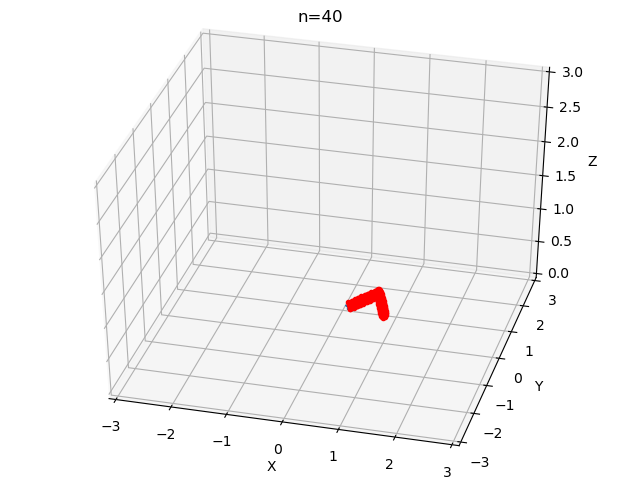

In [11]:
# realtime update of points in 3D

%matplotlib notebook

fig = plt.figure()
ax = p3.Axes3D(fig)

ax.set_xlim3d([-3.0, 3.0])
ax.set_xlabel('X')

ax.set_ylim3d([-3.0, 3.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 3.0])
ax.set_zlabel('Z')

left_track_ini,right_track_ini,left_track_new = get_test_vals()

wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    right_track_ini,
                                                                    length_l_wrist,
                                                                    length_l_elbow,
                                                                    forearm_radius)

shoulder_in_right_tracker_CS =  get_upperarm_tf(left_track_ini,
                                                right_track_ini,
                                                length_r_shoulder,
                                                upper_arm_radius)

x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                     elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_ini,
                   right_track_ini)

points, = ax.plot(x, y, z, '*')
txt = fig.suptitle('')
l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
             np.array([left_track_ini[1,3],right_track_ini[1,3]]),
             np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

radial_density = 10
height_density = 10
start_point_f = np.array([x[1],y[1],z[1]])
end_point_f  = np.array([x[0],y[0],z[0]])
point_on_cylinder_f = left_track_ini[:3,3]

start_point_u = np.array([x[2],y[2],z[2]])
end_point_u  = np.array([x[1],y[1],z[1]])
point_on_cylinder_u = right_track_ini[:3,3]

xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,point_on_cylinder_f,radial_density,height_density)
xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,point_on_cylinder_u,radial_density,height_density)
cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

ani=animation.FuncAnimation(fig,
                            update_points,
                            frames=100,
                            fargs=(cyl_u,cyl_f,l,points,left_track_new,right_track_ini))


plt.show()

In [ ]:
#pipeline on a real setup

s = socket.socket()
print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)

print("writing calibration data")
right_hand_prev,left_hand_prev = processData()
keyboard.wait('esc')

wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    right_track_ini,
                                                                    length_l_wrist,
                                                                    length_l_elbow,
                                                                    forearm_radius)

shoulder_in_right_tracker_CS =  get_upperarm_tf(left_track_ini,
                                                right_track_ini,
                                                length_r_shoulder,
                                                upper_arm_radius)


while True:
        right_hand_new ,left_hand_new = processData()
        print("left hand tf")
        print(right_hand_new) 
        print("right_hand")
        print(left_hand_new)



socket created 
socket binded to port 
socket listensing ... 


In [ ]:
#test cyl generation

start_point = np.array([0,0,0])
end_point = np.array([0,1,0])
point_on_cylinder = np.array([0,0,1])
radial_density = 30
height_density = 10
x,y,z = cylinder_generation(start_point,end_point,point_on_cylinder,radial_density,height_density)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.set_xlim3d([-3.0, 3.0])
ax.set_xlabel('X')

ax.set_ylim3d([-2.0, 2.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 5.0])
ax.set_zlabel('Z')

plot_points, = ax.plot(x, y, z, '*')
plt.show()

In [7]:
a = "abcd1234"
print(a[1:5])
print(type(a.find("2")+1))print(a[a.find("2")])

bcd1
<class 'int'>
2
